<a href="https://colab.research.google.com/github/DivyaRoopa123/Intern-week--1/blob/main/week_3_mini_project6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
# 1. Install / import libs (Colab usually already has these)
!pip install -q scikit-learn

import os
import random
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

print("TensorFlow version:", tf.__version__)

SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)


TensorFlow version: 2.19.0


In [35]:

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()


y_train = y_train.ravel()
y_test = y_test.ravel()

print("Train images:", x_train.shape, "Train labels:", y_train.shape)
print("Test  images:", x_test.shape,  "Test labels:",  y_test.shape)


class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']


Train images: (50000, 32, 32, 3) Train labels: (50000,)
Test  images: (10000, 32, 32, 3) Test labels: (10000,)


In [36]:
IMG_SIZE = 96   # MobileNetV2 works fine at 96, 128, or 224. 96 is faster.
BATCH_SIZE = 64
AUTOTUNE = tf.data.AUTOTUNE
NUM_CLASSES = 10

from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess

def preprocess_image(image, label):
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = tf.cast(image, tf.float32)
    image = mobilenet_preprocess(image)
    return image, label


data_augment = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.08),
    layers.RandomZoom(0.08),
], name="data_augmentation")

def augment_image(image, label):
    image = data_augment(image, training=True)
    return image, label


train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = train_ds.shuffle(10000, seed=SEED).map(lambda x,y: (tf.cast(x, tf.float32), y), num_parallel_calls=AUTOTUNE)
train_ds = train_ds.map(preprocess_image, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.map(lambda x,y: (data_augment(x, training=True), y), num_parallel_calls=AUTOTUNE)
train_ds = train_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).map(preprocess_image, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)


In [37]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
base_model.trainable = False

inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model(inputs, training=False)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)
model = keras.Model(inputs, outputs, name="mobilenetv2_cifar10")

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "mobilenetv2_cifar10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_18 (InputLayer)     │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_96             │ (None, 1280)           │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,270,794 (8.66 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [38]:


EPOCHS = 5

history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds
)


Epoch 1/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 501s 624ms/step - accuracy: 0.5913 - loss: 1.2530 - val_accuracy: 0.8225 - val_loss: 0.5095
Epoch 2/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 471s 601ms/step - accuracy: 0.7412 - loss: 0.7512 - val_accuracy: 0.8331 - val_loss: 0.4816
Epoch 3/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 472s 603ms/step - accuracy: 0.7493 - loss: 0.7288 - val_accuracy: 0.8291 - val_loss: 0.5034
Epoch 4/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 469s 599ms/step - accuracy: 0.7489 - loss: 0.7248 - val_accuracy: 0.8347 - val_loss: 0.4811
Epoch 5/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 445s 567ms/step - accuracy: 0.7548 - loss: 0.7130 - val_accuracy: 0.8322 - val_loss: 0.4871


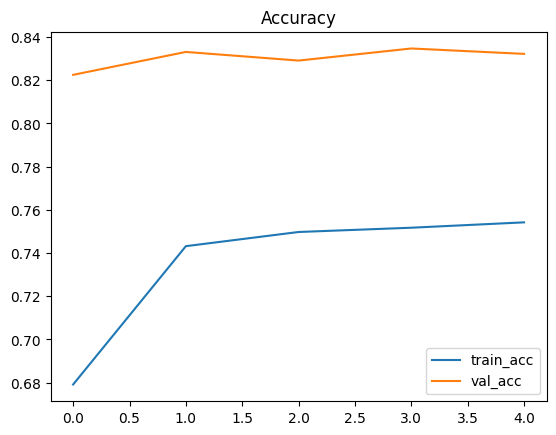

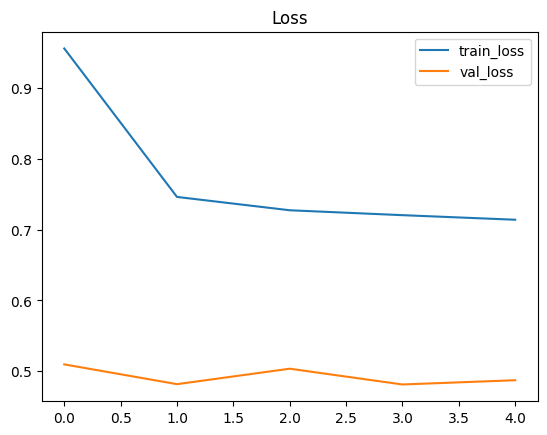

In [39]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.title("Accuracy")
plt.show()

plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.title("Loss")
plt.show()
